<a href="https://colab.research.google.com/github/PhilipRuebeling/master_thesis/blob/main/photonic_devices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}\newcommand{\bra}[1]{\left\langle
{#1}\right|}$$

In [ ]:
%pip install fst-pso  # particle swarm optimization

In [ ]:
import numpy as np
import fstpso as fp

import matplotlib.pyplot as plt
import scipy.special
import math
import numpy as np
import itertools
import pyswarms as ps
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from fstpso import FuzzyPSO
from random import *

# Routines


In [ ]:
def adjoint(A) :
    return np.transpose(np.conjugate(A))

In [ ]:
def pack(parameters_ps, parameters_em, mod_depth) :
    parameters = []
    for k in range(0, n_layers*n_bins) :
        parameters.append(thetaPS[(k//n_bins)][(k%n_bins)])
    for k in range(0, 2*n_layers*mod_depth) :
        parameters.append(thetaEOM[k//(2*mod_depth)][(k%(2*mod_depth))])
    return parameters

In [ ]:
def unpack(parameters, mod_depth) :
    parameters_ps = np.zeros(shape=(n_layers, n_bins), dtype='float')
    parameters_em = np.zeros(shape=(n_layers, 2*mod_depth), dtype='float')
    for k in range(0, n_layers*n_bins) :
        thetaPS[(k//n_bins)][(k%n_bins)] = parameters[k]
    for k in range(0, 2*n_layers*mod_depth) :
        thetaEOM[k//(2*mod_depth)][(k%(2*mod_depth))] = parameters[(k + n_bins*n_layers)]
    return [thetaPS, thetaEOM]

# Electro-optic modulator (EOM)


[Electro-optic modulator](https://en.wikipedia.org/wiki/Electro-optic_modulator) (EOM) have broad ranges of application in classical and quantum photonics. is described by its driving voltage

$a(t) = \sum_{k=1}^{m} a_{k}\sin(\Omega_{k} t + \varphi_{k})$

Here we call $m = 1, 2, \dots$ the modulation depth. When we concentrate on single-tone modulation we will set this to be equal to $1$.

$a^{\dagger}_{r} \rightarrow Sa^{\dagger}_{r}S^{\dagger} = \sum_{q} (-ie^{-i\vartheta})^{q} J_{q}(m)a^{\dagger}_{r+q}$.

In [ ]:
global mod_depth = 1     # modulation depth
global a_min = 00.00     # minimal modulation amplitude
global a_max = 10.00     # maximal modulation amplitude

This defines the unitary in time domain (TD).

In [ ]:
def unitaryTD(parameters, mod_depth, n_bins) :
    U = np.zeros(shape=(n_bins, n_bins), dtype="complex64")
    amplitude, phase = parameters
    for i in range(0, d):
        U[i][i] += np.exp(1j*(amplitude*np.sin(np.pi*i/d + phase)))
    return U

In [ ]:
# testing if unitaryTD returns a unitary matrix
U = np.around(unitaryTD(parameters, mod_depth, n_bins), decimals=9)
is_unitary = np.allclose(np.eye(n_bins), U @ RT.adjoint(U))
print('unitaryTD() returns a unitary matrix: ' + str(is_unitary))

Plotting the modulation signal

In [ ]:
def plot_modulation(parameters, mod_depth, n_bins) :
    amplitude, phase = parameters
    t = np.arange(0, 10*n_bins)
    s = np.around(amplitude*np.sin(np.pi*t/n_bins + phase), decimals=9)
    plt.title('modulation signal ot the EOM in TD')
    plt.plot(t/n_bins, s)
    plt.xlabel('time [norm.]')
    plt.ylabel('driving voltage [arb.]')
    plt.show()
    plt.close()
    pass

In [ ]:
plot_modulation(parameters, mod_depth, n_bins)

Here is the corresponding unitary in frequency domain (FD).

In [ ]:
def unitaryFD(parameters, mod_depth, n_bins) :
    F = dft(n_bins)/np.sqrt(n_bins)
    U = unitaryTD(parameters, mod_depth, n_bins) #doesn't involve yet.
    return F @ U @ RT.adjoint(F)

In [ ]:
# testing if unitaryFD returns a unitary matrix
U = np.around(unitaryFD(parameters, mod_depth, n_bins), decimals=9)
is_unitary = np.allclose(np.eye(n_bins), U @ RT.adjoint(U))
print('unitaryFD() returns a unitary matrix: ' + str(is_unitary))

In [ ]:
# this function will not return some unitary matrix, 
# since we truncate the hilbert space
def besselFD(parameters, n_bins, f=0.42) :
    U = np.zeros(shape=(n_bins, n_bins), dtype='complex64')
    amplitude, phase = parameters
    for i in range(0, d) :
        for j in range(0, d) :
            if(np.abs(i-j) <= math.ceil(amplitude+2)) :
                U[i][j] = special.jv(i-j, f*amplitude)*(-1j*np.exp(-1j*phase))**(i-j)
    return U

# Phase Shaper (PS)



TODO: explain how the PS works.

In [ ]:
def unitaryFD(parameters, n_bins) :
    U = np.array(np.zeros(shape=(n_bins, n_bins)), dtype='complex64')
    for i in range(0, n_bins):
        U[i][i] = np.exp(1j*theta[i])
    return U

In [ ]:
# testing if unitaryFD returns a unitary matrix
U = np.around(unitaryFD(parameters, n_bins), decimals=9)
is_unitary = np.allclose(np.eye(n_bins), U @ RT.adjoint(U))
print('unitaryFD() returns a unitary matrix: ' + str(is_unitary))

# Quantum Frequency Processor (QFP)

$a_{r} \rightarrow a_{r}' = U a_{r}U^{\dagger} = \sum_{l} V_{rl} a_{l}$

The input state is given by $\ket{l} = \sqrt{(1 + \delta_{p_{l} q_{l}})^{-1}} a_{p_{l}}^{\dagger}a_{q_{l}}^{\dagger} \ket{vac}$ and the output state is given by $\ket{m} = \sqrt{(1 + \delta_{p_{m} q_{m}})^{-1}} a_{p_{m}}^{\dagger}a_{q_{m}}^{\dagger} \ket{vac}$

The transfer matrix can be written as $W_{lm} = \bra{l} m \rangle = \sum_{} \frac{V_{} V_{}}{\sqrt{(1 + \delta_{})(1 + \delta_{})}}$

In [ ]:
def transfer_matrix(parameters_ps, parameters_em) :
    W = np.zeros(shape=(d_in, d_out), dtype='complex64')
    V = unitaryV(parameters_ps, parameters_em)
    for l in range(0, d_in) :
        r1, r2 = labelMapping(l)
        for m in range(0, d_out) :
            q1, q2 = labelMapping(m)
            permutations = RT.getPermutations([q1, q2])
            for perm in permutations:
                a, b = perm
                W[l][m]+=1.0/(np.sqrt((1 + diracDelta(r1, r2))*(1 + diracDelta(r1, r2))))*V[r1][a]*V[r2][b]
    return W

coherence and correlation functions

It is well known from the standard beam splitter interference experiments performed by [Hong, Ou and Mandel](https://en.wikipedia.org/wiki/Hong%E2%80%93Ou%E2%80%93Mandel_effect) (1987) that phenomena of quantum interference only arise for indistinguishable bosons. When photons become distingushable in any DoF (i.e. have different quantum numbers) they no longer show such interesting properties. Thus in the given context we might investigate the role of the quantum interference a little bit closer. For instance we could ask what happens, if the photons in a QFP become distinguishable, e.g. by their polarization. Does that have any major consequences on the deep learning performance of the device? 

To investigate such questions, suppose we are able to prepare a quantum state of two photons which have same different polarization, but have the same properties in every other degree of freedom. In the frequency bin setup such state may be written as

$\ket{}$

**Further research:** Besides one and two photon inputs, we might ask what happens if we feed the QFP with other highly non-classical states of ligth. Such states might GHZ (three photons), squeezed states, ...

# Classical Frequency Processor (CFP)

Now, that we have considered the quantum case, we shall examine a classical frequency processor (CFP). Such a device is very similar to the QFP, the only difference being that it operates with classical states of light and usually at higher intensities. Just like in the quantum case we can have "classical" interference between the different frequency bins which is due to the frequncy mixing of the EOM. Due to this observation the following fundamental question arises: can we perform certain deep learning tasks on a CFP just as good as on a QFP? 

Of course it is possible to describe a CFP with classical fields. Here we choose the same quantum framework as we previously encoutered for the QFP to analyse the CFP. This is possbile if we choose as input states of light that are sufficiently "classical" with relativley high intensities. Thus coherent states are a quite natural choice, as they are essentially laser light. 

Of course we could choose other states, epecially mixed states, where we no longer operate in the regime of "pure" coherence. For such states, we expect the interference to become negible. Thus no photon interactions are possible and we expect the CFP to perform bad in deep learning tasks, due to the lack of flexibility of the underlying stochastic model.

Let's get somewhat techncial. A coherent state $\ket{\alpha} = D(\alpha)\ket{vac}$ can be described by applying the displacement operator to the vacuum. The displacement operator is defined by $D(\alpha) = \exp \big(\sum_{r=0}^{M-1} \alpha_{r} a^{\dagger}_{r}+ \alpha_{r}^{*} a_{r} \big)$. It's a reasonable choice to feed the CFP with some "classical" input state, where each frequency bin is uniformly populated by the intensity $I_{r} \propto |\alpha|^{2}$. Formally, this input state may be written as a collection of coherent states $\ket{in} = \ket{\alpha}_{0} \otimes \dots \otimes \ket{\alpha}_{M-1}$, with uniform $\alpha \in \mathbb{C}$ for all frequency bins.

In [ ]:
n_layers, n_bins = 4, 32  # defines the architecture of the CFP

In [ ]:
def unitaryV(parameters_ps, parameters_em) :
    V = np.eye(bins, dtype='complex64')
    for layer in range(0, n_layers) :
        U_em = em.unitaryFD(parameters_em[layer], mod_depth, n_bins)
        U_ps = ps.unitaryFD(parameters_ps[layer], n_bins)
        V = V @ U_ps @ U_eom
    return V

In [ ]:
# uniform intensity distribution
def classical_input_distribution(n_bins) :
  input_state = np.ones(n_bins)
  input_state /= sum(input_state)
  return input_state

In [ ]:
# testing if the distribution is normalized to 1
s = classical_input_distribution(n_bins)
is_normalized = np.allclose(sum(s), 1)
print('classical_input_distribution() returns a normalized distribution: ' + str(is_normalized))

classical_input_distribution() returns a normalized distribution: True


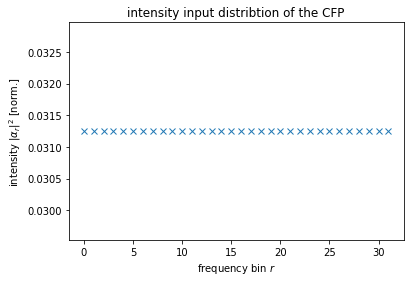

In [53]:
# plotting the input distribtion
plt.plot(np.arange(0, n_bins), s, 'x')
plt.title("intensity input distribtion of the CFP")
plt.xlabel('frequency bin $r$')
plt.ylabel('intensity $|\\alpha_{r}|^2$ [norm.]')
plt.show()

To determine the output state of the CFP we have to revisit the tranfsormation rules for anihilation and creation operators. Previously we obtained the canonical transformation rule $a_{r} \rightarrow a_{r}' = \sum_{l} V_{rl} a_{l}$ for a single frequency bin in the QFP. Results for the CFP can be obtained in strict analogy by subsitution of the transformed operators into the displacement operator for coherent states $D(\alpha) \rightarrow D(\alpha') = \exp(\sum_{r}\alpha_{r}' a_{r} + \text{h.c.})$ we get some collection of coherent states again. As one might would have guessed the parameters of the resulting coherent states are given by $\alpha_{r}' = \sum_{l} V_{rl} \alpha_{l}$. Form this we can obatin the ouput intensity distribution by $I_{r}' \propto |\alpha_{r}'|^{2}$.

In [ ]:
def classical_output_distribution(parameters, mod_depth, n_bins) :
  parameters_ps, parameters_ps = unpack(parameters)
  V = unitaryV(parameters_ps, parameters_em)
  output_state = V @ input_state
  output_distribution = [np.abs(output_state[i])**2 for i in range(0, n_bins)]
  return output_distribution

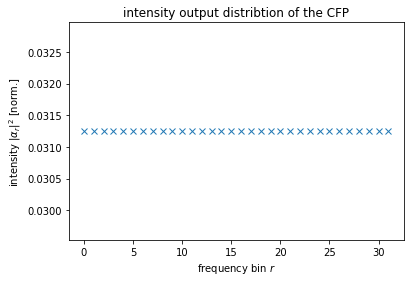

In [54]:
# plotting the output distribtion
plt.plot(np.arange(0, n_bins), s, 'x')
plt.title("intensity output distribtion of the CFP")
plt.xlabel('frequency bin $r$')
plt.ylabel('intensity $|\\alpha_{r}|^2$ [norm.]')
plt.show()

**Future research:** Yet, we have considered states at the border between quantum and classical regime, i.e. coherent states. What happens if we feed the CFP with other "classical" states of light that show lower degrees of coherence? This question seems especially important if we want to quantify the robustness of our device against thermal noise and decoherence. Future investigation could involve mixtures of coherent states $\rho = \frac{1}{2}(\ket{\alpha} \bra{\alpha} + \ket{\beta} \bra{\beta})$ ($\alpha \neq \beta$) as well as partially thermalized coherent states.

# Benchmarking with BAS22

BAS patterns


In [ ]:
def sample_bas22() :
    bas = np.zeros(d)
    bas[0], bas[3], bas[5], bas[10], bas[12], bas[15] = 1, 1, 1, 1, 1, 1
    return bas/6

# Optimization

In [ ]:
swarm_size = 100    # number of particles used in the PSO
iterations = 100    # number of iterations in the PSO 

In [ ]:
def optimize_circuit_fuzzypso(cost_function, search_space) :
  FP = fp.FuzzyPSO()
  FP.set_search_space(search_space)
  FP.set_fitness(cost_function)  
  FP.set_swarm_size(swarm_size)
  best_solution, fitness = FP.solve_with_fstpso(max_iter=iterations)
  return [best_solution, fitness]

In [ ]:
def setupSearchSpace(a_min, a_max) :
    phase_range, amplitude_range = [0, 2*np.pi], [a_min, a_max]
    search_space = []
    for i in range(0, layers*n_bins) :
        search_space.append(phase_range)
    for i in range(0, layers*mod_depth) :
        search_space.append(amplitude_range)
        search_space.append(phase_range)
    return search_space

In [ ]:
search_space = fp.setupSearchSpace(a_min, a_max)

# Evaluation

In [ ]:
# results for QFP with one photon

In [ ]:
# results for QFP with two photons

In [ ]:
# results for CFP with coherent states